In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch 
import os
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import os
import torch
import collections
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from datasets import example_datasets, to_numpy
from torch_models import  MixtureOfTruncNormModel, torch_bpr_uncurried, deterministic_bpr
from torch_perturb.torch_pert_topk import PerturbedTopK
from distributions import QuantizedNormal



2024-09-03 10:29:10.367708: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-03 10:29:10.532739: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 10:29:10.532782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 10:29:10.561723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 10:29:10.626225: I tensorflow/core/platform/cpu_feature_guar

In [2]:
base_dir = '/cluster/tufts/hugheslab/kheuto01/frontier_4000_comp2'
exps = glob.glob(base_dir + '/*')
len(exps)

260

In [3]:
seed=360
# tracts/distributions
S=7

# total timepoints
T= 500
K=5

dist_S = [QuantizedNormal(10, 0.3),
          QuantizedNormal(20, 0.3),
          QuantizedNormal(30, 0.3),
          QuantizedNormal(40, 0.3),
          QuantizedNormal(50, 0.3),
          QuantizedNormal(60, 0.3),
          QuantizedNormal(100, 0.3)]

train_y_TS = np.zeros((T, S))
for s, dist in enumerate(dist_S):
    random_state = np.random.RandomState(10000 * seed + s*123456)
    train_y_TS[:, s] = dist.rvs(size=T, random_state=random_state)

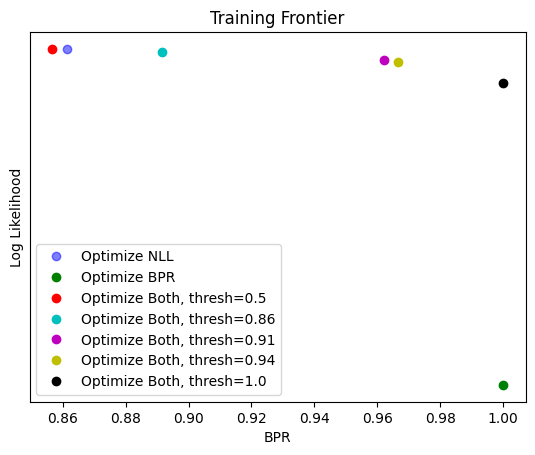

In [4]:
nll_bprs = []
nll_nlls = []
nll_bprs_by_init = -np.inf
nll_nlls_by_init = -np.inf
nll_losses_by_init = np.inf
nll_exp_by_init = collections.defaultdict(str)
bpr_bprs = []
bpr_nlls = []
bpr_bprs_by_init = -np.inf
bpr_nlls_by_init = -np.inf
bpr_losses_by_init = np.inf
bpr_exp_by_init = collections.defaultdict(str)
both_bprs = []
both_nlls = []
both_bprs_by_thresh = collections.defaultdict(lambda: -np.inf)
both_nlls_by_thresh = collections.defaultdict(lambda: -np.inf)
both_losses_by_thresh = collections.defaultdict(lambda: np.inf)
both_exp_by_thresh = collections.defaultdict(lambda: collections.defaultdict(str))
max_nll = -np.inf

for e,exp in enumerate(exps):
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')

    losses = np.array([loss.detach().numpy() for loss in losses])
    bprs = np.array([bpr.detach().numpy() for bpr in bprs])
    nlls = np.array([nll.detach().numpy() for nll in nlls])
    bw = exp.split('bw')[1].split('_')[0]
    nw = exp.split('nw')[1].split('_')[0]
    init = int(exp.split('init')[-1])
    if 'tr' in exp:
        thresh = float(exp.split('_tr')[-1].split('_')[0])
    else:
        thresh = 0

    bpr = bprs[-1]
    nll = -nlls[-1]
    loss = losses[-1]
    if nll > max_nll:
        max_nll = nll


    if bw=='0':
        nll_bprs.append(bprs[-1])
        nll_nlls.append(-nlls[-1])
        if nll > nll_nlls_by_init:
            nll_nlls_by_init = nll
            nll_bprs_by_init = bpr
            nll_exp_by_init = exp
    elif nw=='0':
        bpr_bprs.append(bprs[-1])
        bpr_nlls.append(-nlls[-1])
        if bpr >= bpr_bprs_by_init:
            if nll > bpr_nlls_by_init:
                bpr_bprs_by_init = bpr
                bpr_nlls_by_init = nll
                bpr_exp_by_init = exp
    else:
        both_bprs.append(bprs[-1])
        both_nlls.append(-nlls[-1])
        if loss < both_losses_by_thresh[thresh]:
            both_bprs_by_thresh[thresh] = bpr
            both_nlls_by_thresh[thresh] = nll
            both_losses_by_thresh[thresh] = loss
            both_exp_by_thresh[thresh] = exp

plt.plot(nll_bprs_by_init, nll_nlls_by_init, 'bo',alpha=0.5, label='Optimize NLL')
plt.plot(bpr_bprs_by_init, bpr_nlls_by_init, 'go', label='Optimize BPR')
# plot best of both with each thresh in a different color
colors = ['r', 'c', 'm', 'y', 'k']

for i, thresh in enumerate(both_bprs_by_thresh.keys()):
    plt.plot(both_bprs_by_thresh[thresh], both_nlls_by_thresh[thresh], f'{colors[i]}o', label=f'Optimize Both, thresh={thresh}')
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')
# set ylimits to -100000 to 0
#plt.ylim(-1100000, -1000)
# make y axis log scale even with negative values
plt.yscale('symlog', linthresh=1)
plt.title('Training Frontier')
plt.legend()

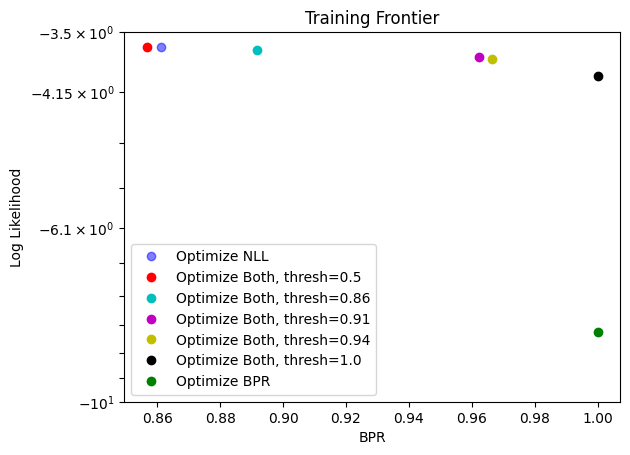

In [28]:
plt.plot(nll_bprs_by_init, nll_nlls_by_init, 'bo',alpha=0.5, label='Optimize NLL')

# plot best of both with each thresh in a different color
colors = ['r', 'c', 'm', 'y', 'k']

for i, thresh in enumerate(both_bprs_by_thresh.keys()):
    plt.plot(both_bprs_by_thresh[thresh], both_nlls_by_thresh[thresh], f'{colors[i]}o', label=f'Optimize Both, thresh={thresh}')
plt.plot(bpr_bprs_by_init, bpr_nlls_by_init, 'go', label='Optimize BPR')
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')
# set ylimits to -100000 to 0
#plt.ylim(-1100000, -1000)
# make y axis log scale even with negative values
plt.yscale('symlog', linthresh=1)
# more y ticks
plt.yticks(np.linspace(-10, -3.5, 11))
plt.title('Training Frontier')
plt.legend()

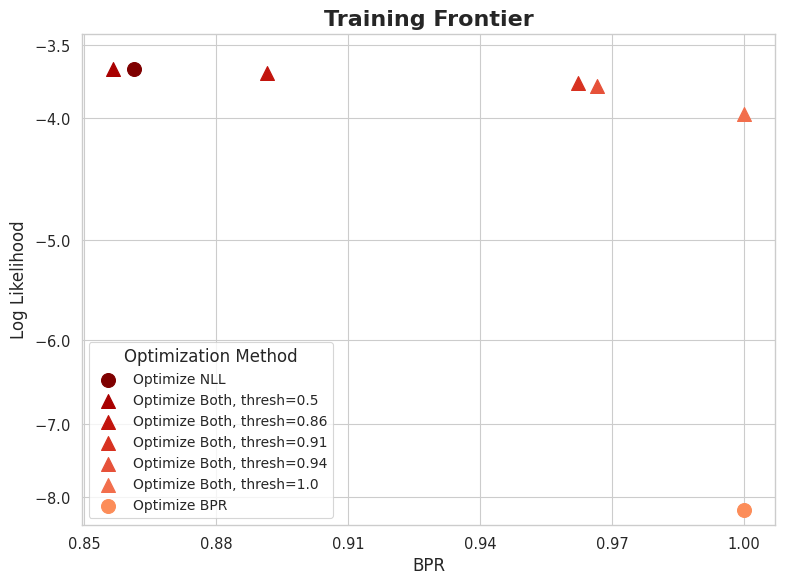

In [45]:
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter

# Set the style for a clean, professional look
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Create a custom OrangeRed colormap
colors =['#7F0000', '#B30000', '#D7301F', '#EF6548', '#FC8D59',]# '#FDBB84', '#FDD49E', '#FEE8C8', '#FFF7EC']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom_orangered', colors, N=n_bins)
# Create a DataFrame for easier plotting
data = []
for thresh in both_bprs_by_thresh.keys():
    data.append({"BPR": both_bprs_by_thresh[thresh], "Log Likelihood": both_nlls_by_thresh[thresh], "Optimization": f"Optimize Both, thresh={thresh}"})
data.append({"BPR": nll_bprs_by_init, "Log Likelihood": nll_nlls_by_init, "Optimization": "Optimize NLL"})
data.append({"BPR": bpr_bprs_by_init, "Log Likelihood": bpr_nlls_by_init, "Optimization": "Optimize BPR"})


df = pd.DataFrame(data)

# Calculate y-axis limits based on the data
y_min = df['Log Likelihood'].min()
y_max = df['Log Likelihood'].max()
y_range = y_max - y_min
y_padding = 0.05 * y_range  # 5% padding
y_min_padded = y_min - y_padding
y_max_padded = y_max + y_padding

# Create the plot
plt.figure(figsize=(8,6))

# Plot "Optimize Both" points
both_data = df[df['Optimization'].str.contains('Optimize Both')]
both_colors = cmap(np.linspace(0.2, 0.8, len(both_data)))
for (_, row), color in zip(both_data.iterrows(), both_colors):
    plt.scatter(row['BPR'], row['Log Likelihood'], color=color, s=100, marker='^', label=row['Optimization'])

# Plot "Optimize NLL" points
nll_data = df[df['Optimization'] == 'Optimize NLL']
plt.scatter(nll_data['BPR'], nll_data['Log Likelihood'], color=colors[0], s=100, marker='o', label='Optimize NLL')

# Plot "Optimize BPR" points
bpr_data = df[df['Optimization'] == 'Optimize BPR']
plt.scatter(bpr_data['BPR'], bpr_data['Log Likelihood'], color=colors[-1], s=100, marker='o', label='Optimize BPR')

# Customize the plot
plt.title("Training Frontier", fontsize=16, fontweight='bold')
plt.xlabel("BPR", fontsize=12)
plt.ylabel("Log Likelihood", fontsize=12)

# Set y-axis to symlog scale with data-driven limits


# add x and y ticks
plt.xticks(np.linspace(0.85, 1, 6))
# make y ticks log space between -8.5 and -3.5


#plt.ylim(y_min_padded, y_max_padded)
plt.yscale('symlog', linthresh=0.1)
# Create a ScalarFormatter object
formatter = ScalarFormatter(useOffset=False)

# Set the formatter to use a fixed number of decimal places
formatter.set_scientific(False)
formatter.set_useMathText(True)

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)
plt.yticks([ -3.5,-4,-5,-6,-7, -8])

# Adjust legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Create a list of labels in the desired order
desired_order = ['Optimize NLL'] + [label for label in labels if label not in ['Optimize NLL', 'Optimize BPR']] + ['Optimize BPR']

# Create the legend with the desired order
plt.legend([by_label[label] for label in desired_order], desired_order,
          title="Optimization Method", title_fontsize='12', fontsize='10', 
          loc='lower left')

# Adjust layout to prevent cutoff
plt.tight_layout()

In [7]:
np.logspace(-10, -3.5, 11)

array([1.00000000e-10, 4.46683592e-10, 1.99526231e-09, 8.91250938e-09,
       3.98107171e-08, 1.77827941e-07, 7.94328235e-07, 3.54813389e-06,
       1.58489319e-05, 7.07945784e-05, 3.16227766e-04])

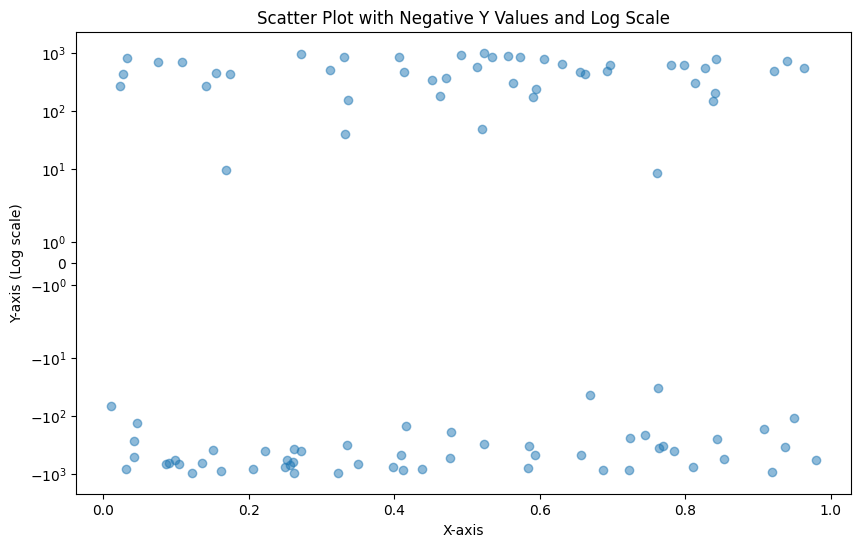

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
x = np.random.rand(100)
y = np.random.uniform(-1000, 1000, 100)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis (Log scale)')
plt.title('Scatter Plot with Negative Y Values and Log Scale')

# Set y-axis to symlog scale
plt.yscale('symlog', linthresh=3)

# Adjust y-axis ticks if needed
plt.yticks([-1000, -100, -10, -1, 0, 1, 10, 100, 1000])

# Show the plot
#plt.grid(True)
plt.show()